In [1]:
import sys
import os
import logging

import yaml

import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy import integrate

import matplotlib
import matplotlib.pyplot as plt

import pyabf

import detector as det


# Data uploading

In [26]:
FORMAT = "%(asctime)s| %(levelname)s [%(filename)s: - %(funcName)20s]  %(message)s"
logging.basicConfig(level=logging.INFO,
                    format=FORMAT)

np.seterr(divide='ignore', invalid='ignore')

data_path = os.getcwd() + '/demo_data'
res_path = os.getcwd() + '/results'
if not os.path.exists(res_path):
    os.makedirs(res_path)

reg_list = det.ABFpars(data_path)
demo = True
save_csv = False

2023-09-14 11:34:44,906| INFO [detector.py: -              ABFpars]  Methadata file metha.yml uploaded!
2023-09-14 11:34:45,375| INFO [detector.py: -              ABFpars]  File 2020_11_24_0021.abf uploaded!


# Thresholds calc & data frame creation

In [31]:
# df init
df = pd.DataFrame(columns=['file',      # file name
                           'app_time',  # application time
                           'v_max',     # AP max amplitude
                           't_max',     # AP max time
                           'v_th',      # threshold voltage
                           't_th',      # threshold time
                           'power'])    # AP power

# loop over input registrations
for reg in reg_list:
    logging.info(f'Registration {reg.fileName} in progress')

    # loop over sweeps
    # for i in range(0, reg.sweepCount):

    # spike detection and extraction
    reg_spike_peak, reg_spike_interval = det.spike_detect(reg, spike_h=-10)
    spike_array = det.spike_extract(reg.sweepY_no_gap, reg_spike_interval)

    # croped array 
    voltage_array = np.array([i[3:-3] for i in spike_array])  # voltage axis, resize to der size
    time_line = np.arange(np.shape(voltage_array)[1])*reg.dataSecPerPoint  # time axis for derivate data (sec)

    # derivate section
    der_array = [det.der(i, reg.dataSecPerPoint) for i in spike_array]
    der2_array = [det.der2(i, reg.dataSecPerPoint) for i in spike_array]
    der3_array = [det.der3(i, reg.dataSecPerPoint) for i in spike_array]

    # threshold calc
    g_t_array, g_t_max = det.g_t(der_array, der2_array,
                             noise_win=100, noise_tolerance=15)  # 15 noise SD, realy?!

    # loop over APs and df writing
    v_th_list = []  # list of absolute AP threshold values
    ap_pow_list = []  # list of AP power values
    for i in range(0, len(voltage_array)):
        
        # extract AP max amplitude
        v_max = max(voltage_array[i])
        v_max_i = voltage_array[i] == v_max
        t_max = time_line[v_max_i][0]

        # extract Vth
        th_i = g_t_max[i][0][0]
        # logging.info(f'Threshold index {th_i}')
        v_th = round(float(voltage_array[i][th_i]), 3)
        t_th = float(time_line[th_i])
        v_th_list.append(v_th)

        # AP power calc
        ap_pow = int(integrate.cumtrapz(der_array[i], voltage_array[i], initial=0)[-1])
        ap_pow_list.append(ap_pow)

        reg_df = pd.DataFrame({'file':reg.fileName,     # file name
                               'app_time':reg.appTime,  # application time
                               'v_max':v_max,           # AP max amplitude
                               't_max':t_max,           # AP max time
                               'v_th':v_th,             # threshold voltage
                               't_th':t_th,             # threshold time
                               'power':ap_pow},         # AP power
                               index=[0])
        
        df = pd.concat([reg_df, df], ignore_index=True)

if save_csv:
  df.to_csv(f'{res_path}/results.csv', index=False)
  logging.info('CSV file saved')        
df

2023-09-14 11:37:14,417| INFO [674867916.py: -             <module>]  Registration 2020_11_24_0021 in progress
2023-09-14 11:37:14,467| INFO [detector.py: -         spike_detect]  Left limit too large, l_lim = 20ms
2023-09-14 11:37:14,468| INFO [detector.py: -         spike_detect]  Right limit too large, r_lim = 50ms
2023-09-14 11:37:14,469| INFO [detector.py: -         spike_detect]  12 peaks in 12 sweeps, thr. = -10mV
/tmp/ipykernel_8201/674867916.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([reg_df, df], ignore_index=True)


,file,app_time,v_max,t_max,v_th,t_th,power
0,2020_11_24_0021,30,44.622799,0.01985,-38.159,0.01895,18965594
1,2020_11_24_0021,30,44.897457,0.01985,-36.267,0.01905,19550022
2,2020_11_24_0021,30,45.446774,0.01985,-37.500,0.01900,20213123
3,2020_11_24_0021,30,44.818111,0.01985,-37.671,0.01895,19230604
4,2020_11_24_0021,30,45.312496,0.01985,-37.299,0.01895,19513458
5,2020_11_24_0021,30,45.135494,0.01985,-37.738,0.01900,19586725
6,2020_11_24_0021,30,43.957516,0.01985,-38.068,0.01890,18862923
7,2020_11_24_0021,30,45.117184,0.01985,-36.279,0.01905,19747357
8,2020_11_24_0021,30,44.915768,0.01985,-36.890,0.01900,19309116
9,2020_11_24_0021,30,44.757076,0.01985,-36.969,0.01905,19712786


# Plotting

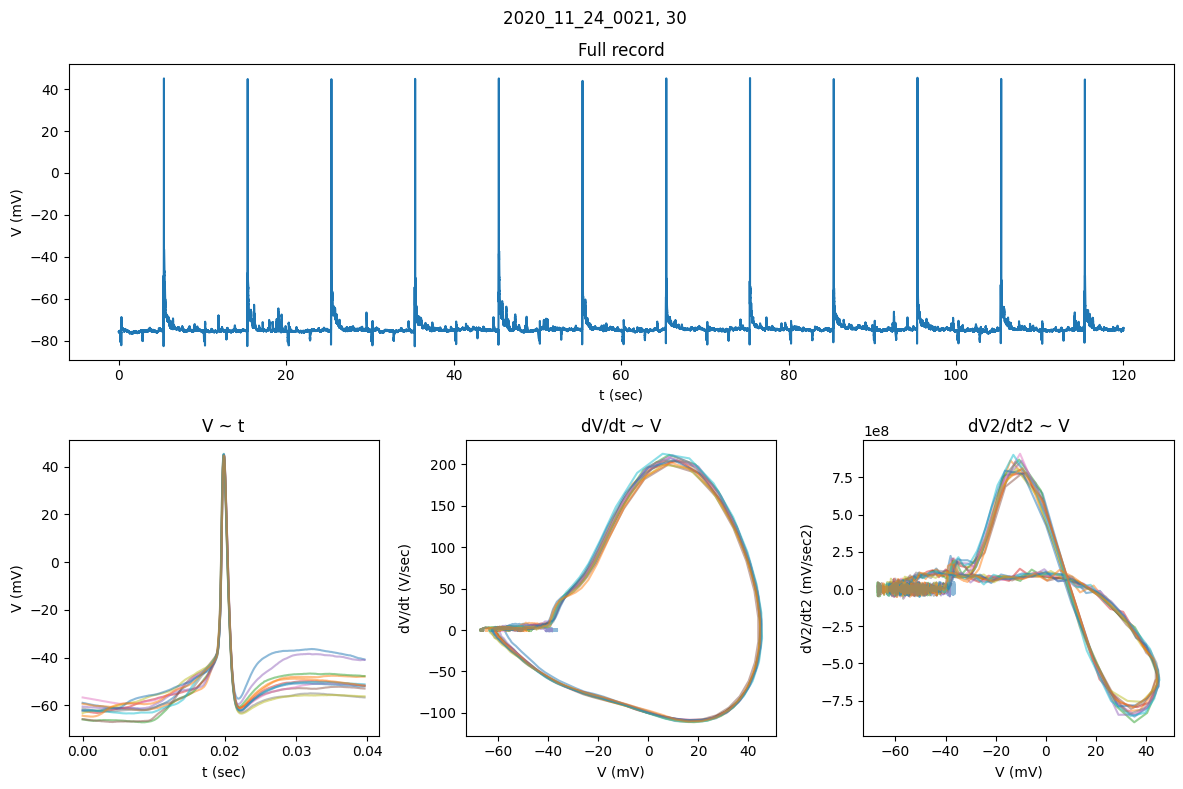

In [32]:
# ctrl plot section
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f'{reg.fileName}, {reg.appTime}')

ax0 = fig.add_subplot(211)
ax0.set_title('Full record')
ax0.set_xlabel('t (sec)')
ax0.set_ylabel('V (mV)')
ax0.plot(reg.sweepX_no_gap, reg.sweepY_no_gap)

ax1 = fig.add_subplot(234)
ax1.set_title('V ~ t')
ax1.set_xlabel('t (sec)')
ax1.set_ylabel('V (mV)')

ax2 = fig.add_subplot(235)
ax2.set_title('dV/dt ~ V')
ax2.set_xlabel('V (mV)')
ax2.set_ylabel('dV/dt (V/sec)')

ax3 = fig.add_subplot(236)
ax3.set_title('dV2/dt2 ~ V')
ax3.set_xlabel('V (mV)')
ax3.set_ylabel('dV2/dt2 (mV/sec2)')

for i in range(0, len(der_array)):
    ax1.plot(time_line, voltage_array[i], alpha=.5)
    ax2.plot(voltage_array[i], der_array[i]/1e3, alpha=.5)
    ax3.plot(voltage_array[i], der2_array[i], alpha=.5)

plt.tight_layout()

if demo:
    plt.show()
else:
    plt.savefig(f'{res_path}/{reg.fileName}_ctrl_img.png')
    plt.close('all')
    logging.info('Ctrl img saved\n')